In [1]:
from meta_info import *
from tools import *
from plot import *
from ntpath import join
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import os
import math
from preprocessing import *

In [7]:
def run(data_root):

    datadir = join(data_root, 'GIMMS3g_NDVI')

    clean(datadir)
    resample_merge(datadir)
    monthly_compose(datadir, method='max')
    deseason_detrend(datadir)
    Month_to_daily(datadir)
    HANTS().run(datadir)
    growing_season_mask_monthly(datadir)

def calculate_growing_season(growing_season_mask):
    """
    计算生长季开始时间、结束时间、长度

    """
    growing_season_start = xr.full_like(growing_season_mask.astype(float), np.nan)  # 初始化，所有值为NaN
    growing_season_end = xr.full_like(growing_season_mask.astype(float), np.nan)  # 初始化，所有值为NaN
    growing_season_lenth = xr.full_like(growing_season_mask.astype(float), np.nan)  # 初始化，所有值为NaN

    # 遍历每个地理位置
    for lat in tqdm(growing_season_mask.lat.values):
        for lon in growing_season_mask.lon.values:
            # 提取单个像元的温度和掩码
            pixel_growing_season_mask = growing_season_mask.sel(lat=lat, lon=lon)
            
            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_growing_season_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

            
                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_growing_season_mask.time) and pixel_growing_season_mask[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    start_time = pixel_growing_season_mask.time[start_idx].values  # 获取生长季开始时间  
                    start_month_of_year  = pd.to_datetime(start_time).month
                    end_time = pixel_growing_season_mask.time[end_idx - 1].values  # 获取生长季结束时间
                    end_month_of_year  = pd.to_datetime(end_time).month
                    # 转换为 pandas Timestamp
                    start_timestamp = pd.to_datetime(start_time)
                    end_timestamp = pd.to_datetime(end_time)
                    # 计算月份差异
                    length_months = (end_timestamp.year - start_timestamp.year) * 12 + end_timestamp.month - start_timestamp.month + 1
                    # length = np.datetime64(end_time) - np.datetime64(start_time)# 获取生长季长度
                    # length_days = length.astype('timedelta64[D]').astype(int) + 1  
                    growing_season_start.loc[{'lat': lat, 'lon': lon, 'time': pixel_growing_season_mask.time[start_idx]}] = start_month_of_year
                    growing_season_end.loc[{'lat': lat, 'lon': lon, 'time': pixel_growing_season_mask.time[start_idx]}] = end_month_of_year
                    growing_season_lenth.loc[{'lat': lat, 'lon': lon, 'time': pixel_growing_season_mask.time[start_idx]}] = length_months

                  
    growing_season_start.to_netcdf(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_start.nc4')
    growing_season_end.to_netcdf(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_end.nc4')
    growing_season_lenth.to_netcdf(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_lenth.nc4')        

    return growing_season_start, growing_season_end, growing_season_lenth

def drop_consecutive_drought(drought_mask):
    """
    去除两年内连续发生的干旱

    """
    drop_nyear_drought = drought_mask.copy()

    # 遍历每个地理位置
    for lat in tqdm(drop_nyear_drought.lat.values):
        for lon in drop_nyear_drought.lon.values:
            # 提取单个像元的温度和掩码 
            pixel_drought_mask = drought_mask.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                for i, start_idx in enumerate(region_starts):
                    if i + 1 < len(region_starts):
                        months_between = region_starts[i+1] - region_starts[i]
                        if months_between <=24:
                            next_end_idx = region_starts[i+1] +1
                            while next_end_idx < len(pixel_drought_mask.time) and pixel_drought_mask[next_end_idx] == 1:
                                next_end_idx += 1  # 找到连续区间的结束索引
                            region_drought = pixel_drought_mask.isel(time=slice(int(start_idx), int(next_end_idx)))  
                            drop_nyear_drought.loc[{'lat': lat, 'lon': lon, 'time': region_drought.time}] = np.nan
                                                       
    return  drop_nyear_drought 

def drop_consecutive_all_drought(drought_mask, another_drought_mask):
    """
    去除两年内连续发生的干旱

    """
    drop_nyear_drought = drought_mask.copy()

    # 遍历每个地理位置
    for lat in tqdm(drop_nyear_drought.lat.values):
        for lon in drop_nyear_drought.lon.values:
            # 提取单个像元的温度和掩码 
            pixel_drought_mask = drought_mask.sel(lat=lat, lon=lon)
            pixel_another_drought_mask = another_drought_mask.sel(lat=lat, lon=lon)
            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                for i, start_idx in enumerate(region_starts):
                    if i + 1 < len(region_starts):
                        months_between = region_starts[i+1] - region_starts[i]
                        if months_between <=24:
                            next_end_idx = region_starts[i+1] +1
                            while next_end_idx < len(pixel_drought_mask.time) and pixel_drought_mask[next_end_idx] == 1:
                                next_end_idx += 1  # 找到连续区间的结束索引
                            region_drought = pixel_drought_mask.isel(time=slice(int(start_idx), int(next_end_idx)))  
                            drop_nyear_drought.loc[{'lat': lat, 'lon': lon, 'time': region_drought.time}] = np.nan

                    if i < len(region_starts):
                        two_years_later = pd.to_datetime(pixel_drought_mask.time[start_idx].values) + pd.DateOffset(years=2) # 干旱开始后的两年
                        if two_years_later <= (pixel_another_drought_mask.time[-1].values):        
                            two_years_another_drought = pixel_another_drought_mask.sel(time=slice(pixel_drought_mask.time[start_idx].values, two_years_later))
                        else:
                            two_years_another_drought = pixel_another_drought_mask.sel(time=slice(pixel_drought_mask.time[start_idx].values, pixel_another_drought_mask.time[-1].values))
                        if (two_years_another_drought == 1).any():
                            drop_nyear_drought.loc[{'lat': lat, 'lon': lon, 'time': two_years_another_drought.time[0]}] = np.nan
    return  drop_nyear_drought 

def statistic_drought_times(drough_mask):
    """
    计算干旱次数

    """
    drought_times = xr.full_like(drough_mask, np.nan)  

    # 遍历每个地理位置
    for lat in tqdm(drough_mask.lat.values):
        for lon in drough_mask.lon.values:
            # 提取单个像元的温度和掩码 
            pixel_drought_mask = drough_mask.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_drought_mask.time) and pixel_drought_mask[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    region_drought = pixel_drought_mask.isel(time=slice(int(start_idx), int(end_idx)))  
                    drought_times.loc[{'lat': lat, 'lon': lon, 'time': region_drought.time[0]}] = 1
                                                       
    return  drought_times 




In [ ]:
# ds=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Deseason_detrend\deseason_detrend.nc4')
# ds=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Result\drought_frequency.nc')
# ds1=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Source\spei03.nc')
# ds = xr.open_dataset('E:/PHD_Project/Data/GIMMS3g_NDVI/Resample_merge/ndvi3g_geo_v1_2_2021_0712.nc4')
# ds=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Month_to_daily\1988.nc4')
# ds=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Hants_daily\2021.nc4')
# ds1=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Month_to_daily\2021.nc4')
# xr.open_mfdataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Hants_daily\*.nc4', concat_dim='time', combine='nested' )
# ds=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\growing_season_mask_monthly.nc4')
# growing_season_mask=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\growing_season_mask_monthly.nc4').ndvi
# growing_season_mask.isel(time=12).plot()
# growing_season_mask.sel(time=slice('2010-01-01', '2012-01-01')).sel(lon=100, lat=60 , method='nearest').plot()
# growing_season_mask.sel(time=slice('2010-01-01', '2013-01-01')).sel(lon=-50, lat=0 , method='nearest').plot()
# growing_season_mask.sel(time=slice('1982-01-01', '1986-01-01')).sel(lon=-50, lat=-20 , method='nearest').plot()

In [ ]:
datadir_GIMMS = join(data_root, 'GIMMS3g_NDVI')
datadir_SPEI = join(data_root, 'SPEI')

# 生长季开始，结束，长度

In [ ]:
growing_season_mask=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\Growing_season_mask_monthly_leftrightclear.nc4').ndvi
growing_season_start, growing_season_end, growing_season_lenth=calculate_growing_season(growing_season_mask)
growing_season_start=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_start.nc4')
growing_season_end=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_end.nc4')
growing_season_lenth=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_statistic\growing_season_lenth.nc4')
def filter_multigrowing_season(ds):
    
    growing_season_mask = (ds > 0)
    season_starts_per_year = growing_season_mask.sum(dim='time', skipna=True)
    return ds.where(season_starts_per_year <=1)

# 将这些像元在原数据中设置为NaN
growing_season_start_new = growing_season_start.groupby('time.year').apply(filter_multigrowing_season)
growing_season_end_new = growing_season_end.groupby('time.year').apply(filter_multigrowing_season)
growing_season_lenth_new = growing_season_lenth.groupby('time.year').apply(filter_multigrowing_season)
growing_season_start_mean =growing_season_start_new.ndvi.mean(dim='time')
growing_season_end_mean =growing_season_end_new.ndvi.mean(dim='time')
growing_season_lenth_mean =growing_season_lenth_new.ndvi.mean(dim='time')
statistics_2d(growing_season_start_mean)
statistics_2d(growing_season_end_mean)
statistics_2d(growing_season_lenth_mean)
plot_spei2d(growing_season_start_mean, cmap= 'viridis')
plot_spei2d(growing_season_end_mean, cmap= 'viridis')
plot_spei2d(growing_season_lenth_mean, cmap= 'YlGn')

# 计算并统计四种干旱

In [ ]:
normal_drought_times=xr.open_dataset(r'E:\PHD_Project\Results\Drought_types\normal_drought_times.nc').ndvi
extreme_drought_times=xr.open_dataset(r'E:\PHD_Project\Results\Drought_types\extreme_drought_times.nc').ndvi
normal_hot_drought_times=xr.open_dataset(r'E:\PHD_Project\Results\Drought_types\normal_hot_drought_times.nc').ndvi
extreme_hot_drought_times=xr.open_dataset(r'E:\PHD_Project\Results\Drought_types\extreme_hot_drought_times.nc').ndvi

In [ ]:
normal_drought_times_sum = normal_drought_times.sum(dim='time')
extreme_drought_times_sum = extreme_drought_times.sum(dim='time')
normal_hot_drought_times_sum = normal_hot_drought_times.sum(dim='time')
extreme_hot_drought_times_sum = extreme_hot_drought_times.sum(dim='time')

In [ ]:
statistics_2d(normal_drought_times_sum.where(normal_drought_times_sum>0))

In [ ]:
statistics_2d(extreme_drought_times_sum.where(extreme_drought_times_sum>0))

In [ ]:
statistics_2d(normal_hot_drought_times_sum.where(normal_hot_drought_times_sum>0))

In [ ]:
statistics_2d(extreme_hot_drought_times_sum.where(extreme_hot_drought_times_sum>0))

In [ ]:
plot_spei2d(normal_drought_times_sum.where(normal_drought_times_sum>0), cmap='hot', vmax=4)

In [ ]:
plot_spei2d(extreme_drought_times_sum.where(extreme_drought_times_sum>0), cmap='hot', vmax=7)

In [ ]:
plot_spei2d(normal_hot_drought_times_sum.where(normal_hot_drought_times_sum>0), cmap='hot', vmax=4)

In [ ]:
plot_spei2d(extreme_hot_drought_times_sum.where(extreme_hot_drought_times_sum>0), cmap='hot', vmax =4)

In [ ]:
spei=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Source\spei03.nc').spei
growing_season_mask=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\Growing_season_mask_monthly_leftrightclear.nc4').ndvi
tmp=xr.open_dataset(r'E:\PHD_Project\Data\CRU\Source\cru_ts4.07.1901.2022.tmp.dat.nc').tmp
hot_mask=xr.open_dataset(r'E:\PHD_Project\Data\CRU\Hot_drought_tmp\hot_mask.nc').tmp
# 按月重采样到每月开始, 将时间对齐
spei = spei.resample(time='MS').mean()  # 'MS'表示每月的开始，mean()是一种聚合方法，你可以根据需要选择合适的聚合方法
growing_season_mask = growing_season_mask.resample(time='MS').mean()
# 截取ndvi同等时间段
tmp=tmp.resample(time='MS').mean().sel(time=growing_season_mask.time)
spei = spei.sel(time=growing_season_mask.time)
#筛选干旱并提取生长季干旱
normal_hot_drought_mask = growing_season_mask.where((spei < -0.5) & (spei > -1.5) & (hot_mask == 1))
extreme_hot_drought_mask = growing_season_mask.where((spei <= -1.5) & (hot_mask == 1))
normal_drought_mask = growing_season_mask.where((spei < -0.5) & (spei > -1.5) & (normal_hot_drought_mask != 1))
extreme_drought_mask = growing_season_mask.where((spei <= -1.5) & (extreme_hot_drought_mask != 1))

In [ ]:
def caculate_drought(drought_types, out_fname_list):

    results_droped_drought=[]
    results_drought_times=[]

    for i in tqdm(range(len(drought_types))):


        droped_drought=drop_consecutive_drought(drought_types[i])
        
        drought_times=statistic_drought_times(droped_drought)

        results_droped_drought.append(droped_drought)
        results_drought_times.append(drought_times)

        droped_drought.to_netcdf(rf'E:\PHD_Project\Results\Drought_types\{out_fname_list[i]}_droped.nc') 
        drought_times.to_netcdf(rf'E:\PHD_Project\Results\Drought_types\{out_fname_list[i]}_times.nc') 
    
    return results_droped_drought, results_drought_times

In [ ]:
drought_types=[normal_hot_drought_mask, extreme_hot_drought_mask, normal_drought_mask, extreme_drought_mask]
out_fname_list=['normal_hot_drought', 'extreme_hot_drought', 'normal_drought', 'extreme_drought']

In [ ]:
droped_drought, drought_times=caculate_drought(drought_types, out_fname_list)

# 根据干旱强度、高温划分干旱

In [ ]:
def drop_one_month_slight_drought(spei):

    condition = (spei<= -0.5) & (spei>= -0.55)

    # 遍历每个空间位置
    for lat in tqdm(spei.lat, desc='Processing Latitude'):
        for lon in spei.lon:
            # 提取该位置的时间序列
            pixel_spei = condition.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_spei == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                
                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_spei.time) and pixel_spei[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    if end_idx - start_idx <= 1:
                        region_spei = pixel_spei.isel(time=slice(int(start_idx), int(end_idx))) 
                    
                        spei.loc[{'lat': lat, 'lon': lon, 'time': region_spei.time[0]}] = np.nan
                    
    return spei

def caculate_new_drought(drought_types, out_fname_list):

    results_droped_drought=[]
    results_drought_times=[]

    for i in tqdm(range(len(drought_types))):

        if i == 0:
            droped_drought=drop_consecutive_all_drought(drought_types[i], drought_types[i+1])
            drought_times=statistic_drought_times(droped_drought)
            results_droped_drought.append(droped_drought)
            results_drought_times.append(drought_times)
        if i == 1:
            droped_drought=drop_consecutive_all_drought(drought_types[i], drought_types[i-1])
            drought_times=statistic_drought_times(droped_drought)
            results_droped_drought.append(droped_drought)
            results_drought_times.append(drought_times)
            
        droped_drought.to_netcdf(rf'E:\PHD_Project\New_results\Drought_types\{out_fname_list[i]}_droped.nc') 
        drought_times.to_netcdf(rf'E:\PHD_Project\New_results\Drought_types\{out_fname_list[i]}_times.nc') 
    
    return results_droped_drought, results_drought_times

def drought_intensity_duration(drought_mask, spei ):

   
    drought_intensity = xr.full_like(drought_mask, np.nan) 
    drought_duration = xr.full_like(drought_mask, np.nan) 

    # 遍历每个空间位置
    for lat in tqdm(drought_mask.lat, desc='Processing Latitude'):
        for lon in drought_mask.lon:
            # 提取该位置的时间序列
            pixel_drought_mask = drought_mask.sel(lat=lat, lon=lon)
            pixel_spei = spei.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                
                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_drought_mask.time) and pixel_drought_mask[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    region_spei = pixel_spei.isel(time=slice(int(start_idx), int(end_idx)))  
                    result_drought_intensity = -(region_spei.sum())
                    result_drought_duration = end_idx - start_idx + 1
                    drought_intensity.loc[{'lat': lat, 'lon': lon, 'time': region_spei.time[0]}] = result_drought_intensity
                    drought_duration.loc[{'lat': lat, 'lon': lon, 'time': region_spei.time[0]}] = result_drought_duration

    return drought_intensity, drought_duration

def caculate_intensity_durantion(drought_types, out_fname_list ,spei):

    results_intensity=[]
    results_duration=[]

    for i in tqdm(range(len(drought_types))):


        intensity, duration= drought_intensity_duration(drought_types[i], spei)

        results_intensity.append(intensity)
        results_duration.append(duration)

        intensity.to_netcdf(rf'E:\PHD_Project\New_results\Drought_intensity_duration\{out_fname_list[i]}_intensity.nc') 
        duration.to_netcdf(rf'E:\PHD_Project\New_results\Drought_intensity_duration\{out_fname_list[i]}_duration.nc') 
    
    return results_intensity, results_duration

In [ ]:
droped_spei= drop_one_month_slight_drought(spei)
droped_spei.to_netcdf(rf'E:\PHD_Project\Data\SPEI\Result\droped_spei.nc')

In [2]:
spei=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Source\spei03.nc').spei
droped_spei=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Result\droped_spei.nc').spei
growing_season_mask=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\Growing_season_mask_monthly_leftrightclear.nc4').ndvi
tmp=xr.open_dataset(r'E:\PHD_Project\Data\CRU\Source\cru_ts4.07.1901.2022.tmp.dat.nc').tmp
hot_mask=xr.open_dataset(r'E:\PHD_Project\Data\CRU\Hot_drought_tmp\hot_mask.nc').tmp
# 按月重采样到每月开始, 将时间对齐
spei = spei.resample(time='MS').mean()  # 'MS'表示每月的开始，mean()是一种聚合方法，你可以根据需要选择合适的聚合方法
growing_season_mask = growing_season_mask.resample(time='MS').mean()
# 截取ndvi同等时间段
tmp=tmp.resample(time='MS').mean().sel(time=growing_season_mask.time)
spei = spei.sel(time=growing_season_mask.time)
#筛选干旱并提取生长季干旱
hot_drought_mask = growing_season_mask.where((droped_spei < -0.5) & (hot_mask == 1))
normal_drought_mask = growing_season_mask.where((droped_spei < -0.5) & (hot_drought_mask != 1))

In [5]:
drought_types=[normal_drought_mask, hot_drought_mask]
out_fname_list=['normal_drought', 'hot_drought']

In [8]:
droped_drought, drought_times=caculate_new_drought(drought_types, out_fname_list)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

In [9]:
normal_drought_droped=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_types\normal_drought_droped.nc').ndvi
hot_drought_droped=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_types\hot_drought_droped.nc').ndvi

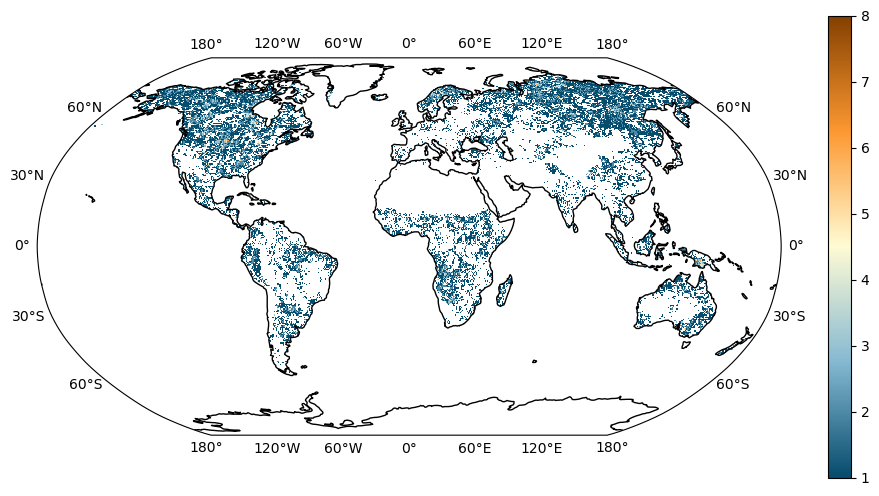

In [31]:
plot_spei2d((drought_times[0].sum(dim= 'time').where(drought_times[0].sum(dim= 'time')>0)), cmap= global_cmap_r)

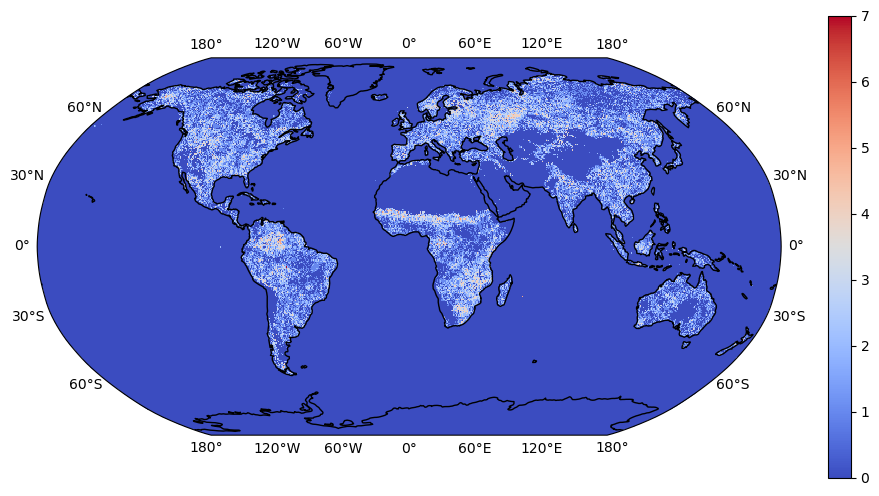

In [32]:
plot_spei2d(drought_times[1].sum(dim= 'time'))

In [12]:
drought_types=[normal_drought_droped, hot_drought_droped]
out_fname_list=['normal_drought', 'hot_drought']

In [13]:
results_intensity, results_duration=caculate_intensity_durantion(drought_types, out_fname_list, spei)

  0%|          | 0/2 [00:00<?, ?it/s]

Processing Latitude:   0%|          | 0/360 [00:00<?, ?it/s]

Processing Latitude:   0%|          | 0/360 [00:00<?, ?it/s]

In [ ]:
hot_drought_intensity=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_intensity_duration\hot_drought_intensity.nc').ndvi
hot_drought_duration=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_intensity_duration\hot_drought_duration.nc').ndvi

In [ ]:
hot_drought_intensity.mean(dim= 'time').plot()

In [ ]:
hot_drought_duration.mean(dim= 'time').plot()

In [ ]:
np.unique((hot_drought_intensity.sel(time=slice('1982-01-01', '2022-01-01')).sel(lon=-50, lat=-20 , method='nearest')))